In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
rcParams.update({'figure.autolayout': True})
rcParams['svg.fonttype'] = 'none'
rcParams['font.size']=10

from keras.models import load_model

import pybedtools

Using Theano backend.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_sxfoz05a.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Preallocating 10619/11178 Mb (0.950000) on cuda
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:1A:00.0)


In [3]:
colorsDict = {"Microglia":'#6b97ff',
              "Monocyte": '#ff6b97',
              "Neuron": '#97ff6b'}

In [4]:
microglia_regression = load_model("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_gosselin_microglia/model_7.hdf5", compile = False)
monocyte_regression = load_model("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_monocyte/model_8.hdf5", compile = False)
neuron_regression = load_model("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_fullard_neun/model_2.hdf5", compile = False)

In [5]:
bulk_models_list = {"Microglia": microglia_regression,
                    "Monocyte": monocyte_regression,
                    "Neuron": neuron_regression}

In [6]:
rootPath = "/".join(["/projects",
                     "pfenninggroup",
                     "machineLearningForComputationalBiology",
                     "eramamur_stuff",
                     "ad_variants_processing",
                     "common_variants"])

In [7]:
scores_file_names = {"Microglia": "/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ad_variants_processing/rare_variants/gosselin_microglia_effect_scores.txt",
                     "Monocyte": "/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ad_variants_processing/rare_variants/encode_monocyte_effect_scores.txt",
                     "Neuron": "/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ad_variants_processing/rare_variants/fullard_put_neun_effect_scores.txt"
                    }

In [8]:
colnames = ["effect_score",
            "ref_score",
            "alt_score"
           ]

effect_score_standard_deviations = {}

for key in scores_file_names:
    scores = pd.read_csv(scores_file_names[key],
                         sep='\t',
                         names=colnames
                         )
    effect_score_standard_deviations[key] = np.std(scores["effect_score"])

In [9]:
region_bed = pybedtools.BedTool(os.path.join(rootPath,"ms4a_region_2_150kb.bed"))
cell_type_beds = {"Monocyte":pybedtools.BedTool(os.path.join("/projects",
                                                              "pfenninggroup",
                                                              "machineLearningForComputationalBiology",
                                                              "eramamur_stuff",
                                                              "gwas_enrichments",
                                                              "roadmap_dnase",
                                                              "encode_monocyte_dhs_optimal_peak_liftover_hg38_to_hg19.narrowPeak")),
                  "Microglia":pybedtools.BedTool(os.path.join("/projects",
                                                              "pfenninggroup",
                                                              "machineLearningForComputationalBiology",
                                                              "eramamur_stuff",
                                                              "gwas_enrichments",
                                                              "roadmap_dnase",
                                                              "gosselin_microglia_exvivo_idr_optimal_peak_liftover_hg38_to_hg19.narrowPeak")),
                  "Neuron":pybedtools.BedTool(os.path.join("/projects",
                                                           "pfenninggroup",
                                                           "machineLearningForComputationalBiology",
                                                           "eramamur_stuff",
                                                           "gwas_enrichments",
                                                           "roadmap_dnase",
                                                           "fullard_neun_put_idr_optimal_peak_liftover_hg38_to_hg19.narrowPeak"))}
    

In [10]:
region_chrom = region_bed[0][0]
region_start = int(region_bed[0][1])
region_end = int(region_bed[0][2])
region_length = region_end-region_start

In [11]:
ref_X = np.load(os.path.join(rootPath,"jansen_snps_intersecting_ms4a_region_2_150kb_reference_X.npy"))
alt_X = np.load(os.path.join(rootPath,"jansen_snps_intersecting_ms4a_region_2_150kb_alternate_X.npy"))
snp_info = pd.read_csv(os.path.join(rootPath,"jansen_snps_intersecting_ms4a_region_2_150kb_hg19_alleles.txt"),
                            sep='\t',
                            header=None,
                            names=["CHR", "START", "END", "SNP", "REF", "ALT", "P", "Z"])

In [12]:
snp_info_bed = pybedtools.BedTool(os.path.join(rootPath,"jansen_snps_intersecting_ms4a_region_2_150kb_hg19_alleles.txt"))

In [13]:
peaksIntersectingRegion = {}
for key in cell_type_beds:
    peaksIntersectingRegion[key] = pybedtools.bedtool.BedTool.intersect(cell_type_beds[key],
                                                              region_bed,
                                                              u=True
                                                             )

In [14]:
snpsIntersectingPeaks = {}
for key in cell_type_beds:
    snpsIntersectingPeaks[key] = pybedtools.bedtool.BedTool.intersect(snp_info_bed,
                                                                      cell_type_beds[key],
                                                                      c=True
                                                                     )

In [15]:
for key in bulk_models_list:
    model = bulk_models_list[key]
    intersecting_or_not = np.array([int(val[8]) > 0 for val in snpsIntersectingPeaks[key]])
    intersecting_or_not = np.reshape(intersecting_or_not, (intersecting_or_not.shape[0],1))
    ref_score = model.predict(ref_X)
    alt_score = model.predict(alt_X)
    effect_score = ref_score - alt_score
    effect_score_normed = effect_score/effect_score_standard_deviations[key]
    snp_info[key+"_intersecting"] = intersecting_or_not
    snp_info[key+"_ref_score"] = [ref_score[i,0] if intersecting_or_not[i,0] else None for i in range(len(ref_score))]
    snp_info[key+"_alt_score"] = [alt_score[i,0] if intersecting_or_not[i,0] else None for i in range(len(alt_score))]
    snp_info[key+"_effect_score"] = [effect_score[i,0] if intersecting_or_not[i,0] else None for i in range(len(effect_score))]
    snp_info[key+"_effect_score_normed"] = [effect_score_normed[i,0] if intersecting_or_not[i,0] else None for i in range(len(effect_score_normed))]

In [16]:
snp_info.loc[snp_info["Microglia_intersecting"]==True]

,CHR,START,END,SNP,REF,ALT,P,Z,Microglia_intersecting,Microglia_ref_score,...,Monocyte_intersecting,Monocyte_ref_score,Monocyte_alt_score,Monocyte_effect_score,Monocyte_effect_score_normed,Neuron_intersecting,Neuron_ref_score,Neuron_alt_score,Neuron_effect_score,Neuron_effect_score_normed
160,chr11,59927037,59927038,rs77457168,C,T,9.957000e-01,0.005389,True,8.281676,...,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
161,chr11,59927038,59927039,rs17529983,G,A,5.748633e-12,6.885744,True,8.145846,...,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
238,chr11,59951364,59951365,rs149566734,G,A,2.632000e-01,-1.118860,True,6.818068,...,True,4.206494,4.127096,0.079398,0.217579,False,NaN,NaN,NaN,NaN
239,chr11,59951432,59951433,rs632185,A,G,7.401696e-12,-6.849677,True,13.802445,...,True,4.523200,4.465478,0.057721,0.158176,False,NaN,NaN,NaN,NaN
252,chr11,59956185,59956186,rs182560848,G,C,6.106000e-01,-0.509217,True,14.336772,...,True,5.919755,5.990668,-0.070914,-0.194329,False,NaN,NaN,NaN,NaN
253,chr11,59956202,59956203,rs76170615,A,T,1.022626e-04,3.885160,True,12.373252,...,True,5.941378,5.779611,0.161767,0.443299,False,NaN,NaN,NaN,NaN
486,chr11,60002934,60002935,rs718376,G,A,2.076967e-13,7.343746,True,12.032887,...,True,6.287304,5.674489,0.612814,1.679328,False,NaN,NaN,NaN,NaN
512,chr11,60010528,60010529,rs535677830,C,G,6.598000e-01,-0.440189,True,15.142854,...,True,5.968421,5.941556,0.026866,0.073622,False,NaN,NaN,NaN,NaN
552,chr11,60019071,60019072,rs186354707,A,G,4.104000e-01,-0.823190,True,16.122974,...,True,8.372684,8.942781,-0.570097,-1.562267,False,NaN,NaN,NaN,NaN
553,chr11,60019149,60019150,rs636317,C,T,2.829881e-13,-7.302253,True,16.858955,...,True,7.884864,5.584596,2.300268,6.303546,False,NaN,NaN,NaN,NaN


0 Monocyte
0.0255 0.02822
0.09775333333333333 0.09940666666666667
0.3582 0.3602666666666667
0.36406 0.3665933333333333
0.44454666666666665 0.44955333333333336
0.44454666666666665 0.44955333333333336
0.45141333333333333 0.4572866666666667
0.45141333333333333 0.4572866666666667
0.45141333333333333 0.4572866666666667
0.46238666666666667 0.4647733333333333
0.48412 0.48606666666666665
0.5181133333333333 0.5221666666666667
0.5943333333333334 0.5959666666666666
0.7964 0.7986533333333333
0.8398066666666667 0.8413933333333333
0.84506 0.8492333333333333
0.84506 0.8492333333333333
0.9040133333333333 0.9061933333333333
0.9072733333333334 0.9106733333333333
0.9072733333333334 0.9106733333333333
0.9834733333333333 0.9861466666666666
0.9981133333333333 1
1 Microglia
0.46226666666666666 0.4649066666666667
0.9834 0.9861466666666666
0.46226666666666666 0.4649066666666667
0.4843133333333333 0.48602
0.9088266666666667 0.91062
0.8459466666666666 0.8488933333333334
0.44734 0.4491733333333333
0.7962933333333

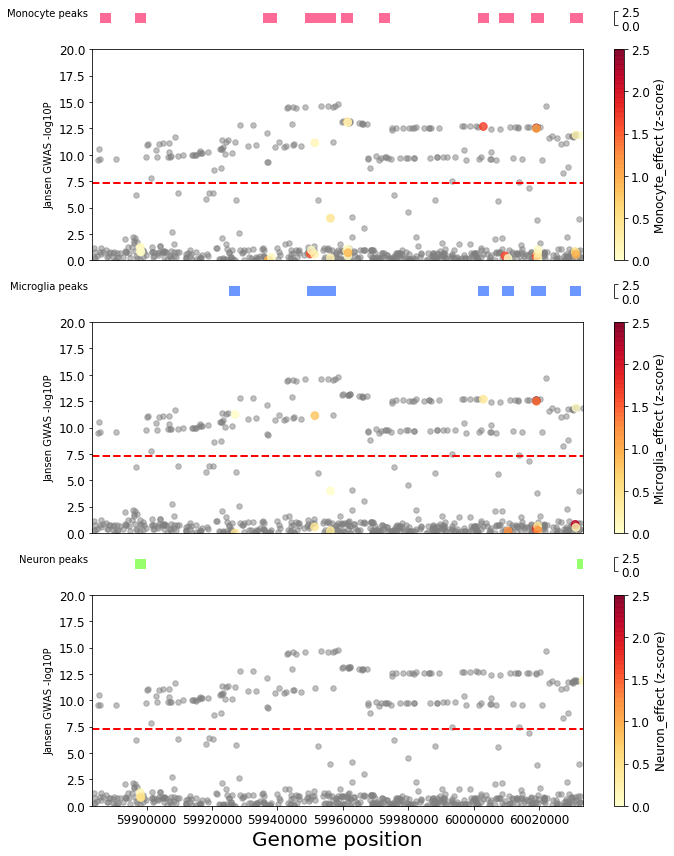

In [61]:
fig,axs = plt.subplots(6,1, figsize=(10,12), gridspec_kw={'height_ratios': [1,15,1,15,1,15]})


for i,key in enumerate(peaksIntersectingRegion):
    print(i,key)
    for interval in peaksIntersectingRegion[key]:
        interval_start = int(interval[1])
        interval_end = int(interval[2])
        plot_start = 1.0*(interval_start - region_start)/(region_length)
        plot_end = 1.0*(interval_end - region_start)/(region_length)
        plot_start = max(plot_start,0)
        plot_end = min(plot_end,1)
        print(plot_start, plot_end)
        axs[2*i].axhline(y=20,xmin=plot_start,xmax=plot_end, lw=10, c=colorsDict[key])
        axs[2*i].set_yticks([])
        axs[2*i].set_ylabel(key+" peaks", rotation='horizontal', horizontalalignment='right')
        axs[2*i].spines['top'].set_visible(False)
        axs[2*i].spines['right'].set_visible(False)
        axs[2*i].spines['bottom'].set_visible(False)
        axs[2*i].spines['left'].set_visible(False)
        
    snp_info_na_snps = snp_info.loc[snp_info[key+"_intersecting"]==False]
    snp_info_scored_snps = snp_info.loc[snp_info[key+"_intersecting"]==True]

    im = axs[2*i+1].scatter(snp_info_na_snps["END"],
                    -np.log10(snp_info_na_snps["P"]),
                    c='gray',
                    alpha=0.5,
                    s=30,
                    rasterized=True)
    im = axs[2*i+1].scatter(snp_info_scored_snps["END"],
                    -np.log10(snp_info_scored_snps["P"]),
                    c=np.absolute(snp_info_scored_snps[key+"_effect_score_normed"]),
                    cmap="YlOrRd",
                    vmin=0,
                    vmax=2.5,
                    alpha=0.8,
                    s=60,
                    rasterized=True)

    axs[2*i+1].tick_params(axis='both', which='major', labelsize=12)
    axs[2*i+1].axhline(y=-np.log10(5e-8), linestyle='--', c='red', linewidth=2)
    axs[2*i+1].set_ylim([0,20])
    axs[2*i+1].set_xlim([region_start, region_end])
    axs[2*i+1].set_ylabel("Jansen GWAS -log10P")
    cb = fig.colorbar(im,ax=axs[2*i+1], orientation='vertical')
    cb.ax.tick_params(labelsize=12)
    cb.set_label(key+"_effect (z-score)", fontsize=12)

    
    cb = fig.colorbar(im,ax=axs[2*i], orientation='vertical')
    cb.ax.tick_params(labelsize=12)


for i in range(len(axs)-1):
    axs[i].set_xticks([])
axs[len(axs)-1].set_xlabel("Genome position",size=20)
axs[len(axs)-1].ticklabel_format(style='plain', useOffset=False)

        
plt.tight_layout()
plt.show()

In [ ]:
#rs636317
#rs76726049

In [ ]:
snp_info.loc[snp_info["SNP"]=="rs636317"]